# notebook to test scat transform

In [18]:
import tensorflow as tf
import os, sys, time, subprocess, h5py, argparse, logging
import numpy as np
from os.path import join as oj
from libs.scattering import scattering
import matplotlib.pyplot as plt
import matplotlib
%matplotlib inline
matplotlib.rcParams['figure.figsize'] = (10, 12)

with h5py.File('data/cifar_100/train.h5') as f:
    ims_orig = f['X'][0:5]

print('ims.shape before', ims_orig.shape)
ims = np.transpose(ims_orig, (0, 3, 1, 2))  # convert NHWC -> NCHW
print('ims.shape after', ims.shape)
im_shape = ims.shape[1:]


# can only run on a gpu
# requires NCHW format (cuDNN default - tf is NHWC)
placeholder = tf.placeholder(tf.float32, (None,) + im_shape)
# M, N: input image size
M, N = placeholder.shape.as_list()[-2:]
print("M", M, "N", N)
# J: number of layers
scat = scattering.Scattering(M=M, N=N, J=1)(placeholder)
M, N = scat.shape.as_list()[-2:]
scat2 = scattering.Scattering(M=M, N=N, J=1)(scat)


def extract_features(placeholder, model, ims):
    print('ims.shape', ims.shape)
    init = tf.global_variables_initializer()
    sess = tf.Session()
    sess.run(init)
    t = time.time()
    output = sess.run(model, feed_dict={placeholder: ims})
    print('features_orig.shape', output.shape)
    return output

with tf.device("/cpu:0"):
    features_orig = extract_features(placeholder=placeholder, model=scat, ims=ims)

ims.shape before (5, 32, 32, 3)
ims.shape after (5, 3, 32, 32)
M 32 N 32
ims.shape (5, 3, 32, 32)
features_orig.shape (5, 27, 16, 16)


In [19]:
with tf.device("/cpu:0"):
    init = tf.global_variables_initializer()
    sess = tf.Session()
    sess.run(init)
    t = time.time()
    [scat, scat2] = sess.run([scat, scat2], feed_dict={placeholder: ims})
    print('scat shape', scat.shape)
    print('scat2 shape', scat2.shape)
    print('time_elapsed', str(time.time() - t))
# convert NCHW -> NHWC
features_new = np.transpose(scat, (0, 2, 3, 1))
features_new2 = np.transpose(scat2, (0, 2, 3, 1))
print('new shapes', features_new.shape, features_new2.shape)

scat shape (5, 27, 16, 16)
scat2 shape (5, 243, 8, 8)
time_elapsed 0.3517129421234131
new shapes (5, 16, 16, 27) (5, 8, 8, 243)


features_new.shape (5, 16, 16, 27)


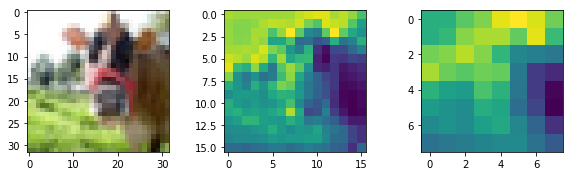

In [20]:
features_summed = np.sum(features_new, axis=3)
features_summed2 = np.sum(features_new2, axis=3)
print('features_new.shape', features_new.shape)
ROWS = 4
N = 3
plt.subplot(ROWS,N,1)
plt.imshow(ims_orig[0])
plt.grid(False)
plt.subplot(ROWS,N,2)
plt.imshow(features_summed[0, :, :])
plt.subplot(ROWS,N,3)
plt.imshow(features_summed2[0, :, :])
plt.show()